In [1]:
import sounddevice as sd
import numpy as np
import librosa
import soundfile as sf
import os

def record_and_trim(filename="zdaj_grem_domov.wav", duration=3, sr=16000):
    folder = "audio_data"
    os.makedirs(folder, exist_ok=True)
    filepath = os.path.join(folder, filename)

    print(f"Recording for {duration} seconds... Please speak clearly.")
    print('Say: "Zdaj grem domov."')

    # Record
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype='float32')
    sd.wait()
    print("Recording finished.")

    audio = audio.flatten()

    # If completely silent, skip trimming
    if np.all(audio == 0):
        print("Warning: No audio detected!")
        sf.write(filepath, audio, sr)
        return

    # Trim silence
    trimmed, _ = librosa.effects.trim(audio, top_db=20)

    # Only normalize if non-zero
    if np.max(np.abs(trimmed)) > 0:
        trimmed = trimmed / np.max(np.abs(trimmed))

    sf.write(filepath, trimmed, sr)
    print(f"Saved trimmed audio to {filepath}")

record_and_trim("zdaj_grem_domov.wav", duration=3)


Recording for 3 seconds... Please speak clearly.
Say: "Zdaj grem domov."
Recording finished.
Saved trimmed audio to audio_data/zdaj_grem_domov.wav


In [2]:
# =============================
# PREPARATION
# =============================
import numpy as np
if not hasattr(np, 'complex'):
    np.complex = complex  # Fix for newer NumPy versions

import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from scipy.fftpack import dct

# Load audio (replace with your own file)
y, sr = librosa.load('audio_data/zdaj_grem_domov.wav', sr=16000)
print(f"Loaded audio: {len(y)/sr:.2f} seconds at {sr} Hz")

# Listen to original
ipd.Audio(y, rate=sr)


Loaded audio: 1.31 seconds at 16000 Hz


STEP 1: Framing into 320 samples per frame, hop 160 samples


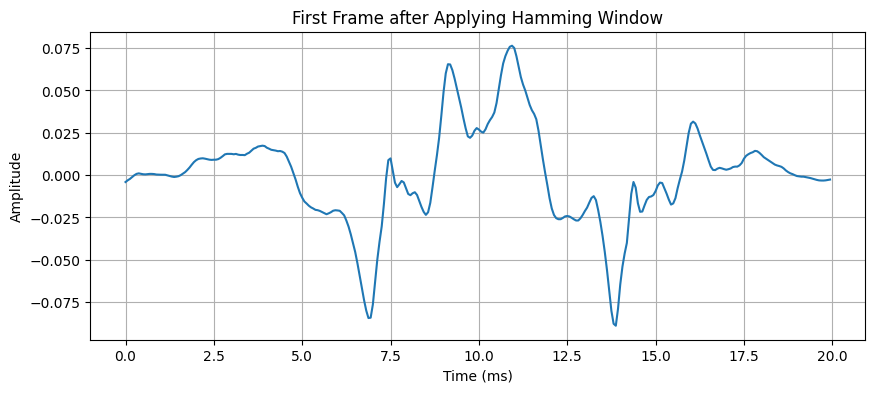

In [3]:
# =============================
# STEP 1 — Frame the audio with Hamming window (20 ms)
# =============================
frame_size = 0.02  # 20 ms
frame_length = int(frame_size * sr)
hop_length = frame_length // 2  # 50% overlap

print(f"STEP 1: Framing into {frame_length} samples per frame, hop {hop_length} samples")

frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length).T
window = np.hamming(frame_length)
windowed_frames = frames * window

# Show first frame waveform
time_axis = np.arange(frame_length) / sr * 1000  # in milliseconds
plt.figure(figsize=(10, 4))
plt.plot(time_axis, windowed_frames[0])
plt.title("First Frame after Applying Hamming Window")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


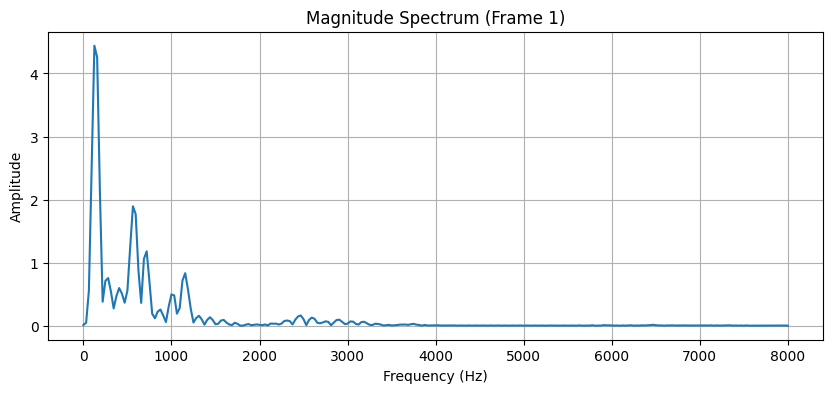

In [4]:
# =============================
# STEP 2 — Compute DFT amplitudes for each frame
# =============================
n_fft = 512
magnitude_frames = np.abs(np.fft.rfft(windowed_frames, n=n_fft))

freqs = np.fft.rfftfreq(n_fft, d=1/sr)  # frequency in Hz

plt.figure(figsize=(10, 4))
plt.plot(freqs, magnitude_frames[0])
plt.title("Magnitude Spectrum (Frame 1)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


STEP 3: Splitting the frequency axis into Mel-spaced bands using triangular filters
--------------------------------------------------------------------------------
We create 26 band-pass filters, each covering a specific range of frequencies.
- Lower-frequency bands are spaced more closely together (linear spacing).
- Higher-frequency bands are spaced further apart (logarithmic spacing), mimicking human hearing.
- The shape of each filter is TRIANGULAR:
    * Center frequency = highest gain (1.0) → passes this frequency fully.
    * Sides = gradual slope to zero gain → partial contribution.
- When we apply these filters to the spectrum from Step 2, we measure how much energy is in each band.
High filter output → strong presence of those frequencies in the signal.
Low filter output  → weak or no presence in that band.



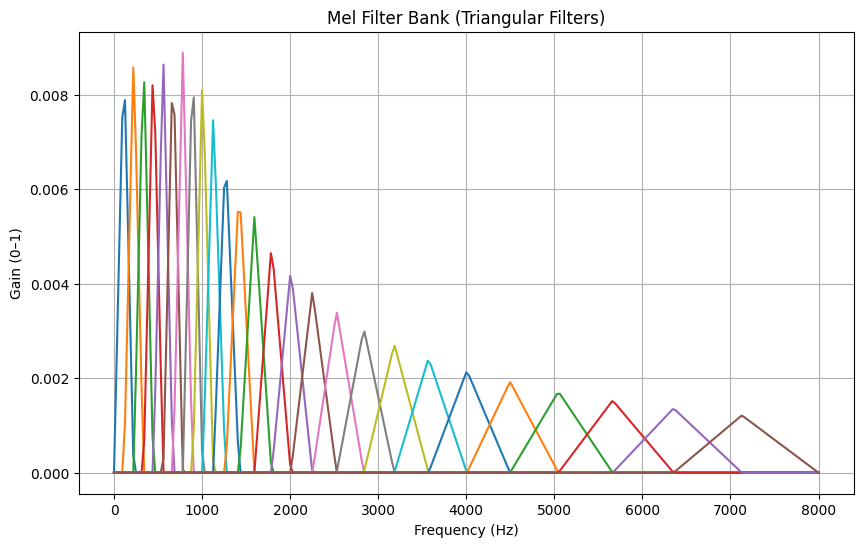

In [5]:
# =============================
# STEP 3 — Split into frequency bands using triangular filter bank (Mel scale)
# =============================

n_filters = 26
mel_filters = librosa.filters.mel(
    sr=sr,
    n_fft=n_fft,
    n_mels=n_filters,
    fmin=0,
    fmax=sr/2
)

print("STEP 3: Splitting the frequency axis into Mel-spaced bands using triangular filters")
print("--------------------------------------------------------------------------------")
print(f"We create {n_filters} band-pass filters, each covering a specific range of frequencies.")
print("- Lower-frequency bands are spaced more closely together (linear spacing).")
print("- Higher-frequency bands are spaced further apart (logarithmic spacing), mimicking human hearing.")
print("- The shape of each filter is TRIANGULAR:")
print("    * Center frequency = highest gain (1.0) → passes this frequency fully.")
print("    * Sides = gradual slope to zero gain → partial contribution.")
print("- When we apply these filters to the spectrum from Step 2, we measure how much energy is in each band.")
print("High filter output → strong presence of those frequencies in the signal.")
print("Low filter output  → weak or no presence in that band.\n")

# Plot the Mel filter bank
plt.figure(figsize=(10, 6))
for i in range(n_filters):
    plt.plot(freqs, mel_filters[i])
plt.title("Mel Filter Bank (Triangular Filters)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain (0–1)")
plt.grid(True)
plt.show()


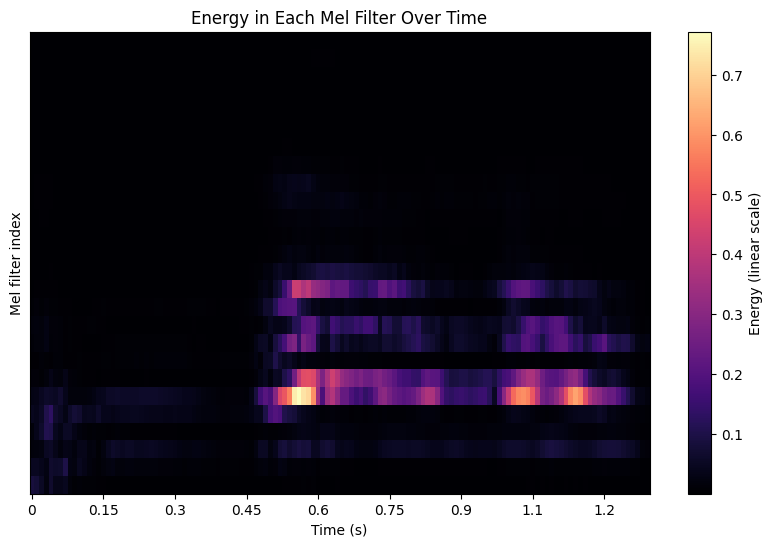

In [6]:
# =============================
# STEP 4 — Sum the energies in each band
# =============================
filter_bank_energies = np.dot(magnitude_frames, mel_filters.T)

plt.figure(figsize=(10, 6))
librosa.display.specshow(
    filter_bank_energies.T,
    x_axis='time', sr=sr, hop_length=hop_length,
    y_axis=None
)
plt.colorbar(label='Energy (linear scale)')
plt.title("Energy in Each Mel Filter Over Time")
plt.ylabel("Mel filter index")
plt.xlabel("Time (s)")
plt.show()


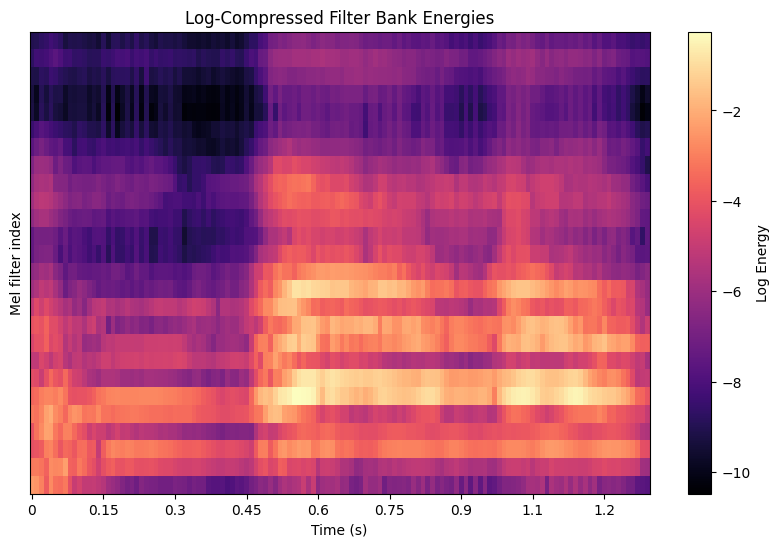

In [8]:
# =============================
# STEP 5 — Apply logarithmic compression
# =============================
log_energies = np.log(filter_bank_energies + 1e-9)

plt.figure(figsize=(10, 6))
librosa.display.specshow(
    log_energies.T,
    x_axis='time', sr=sr, hop_length=hop_length,
    y_axis=None
)
plt.colorbar(label='Log Energy')
plt.title("Log-Compressed Filter Bank Energies")
plt.ylabel("Mel filter index")
plt.xlabel("Time (s)")
plt.show()


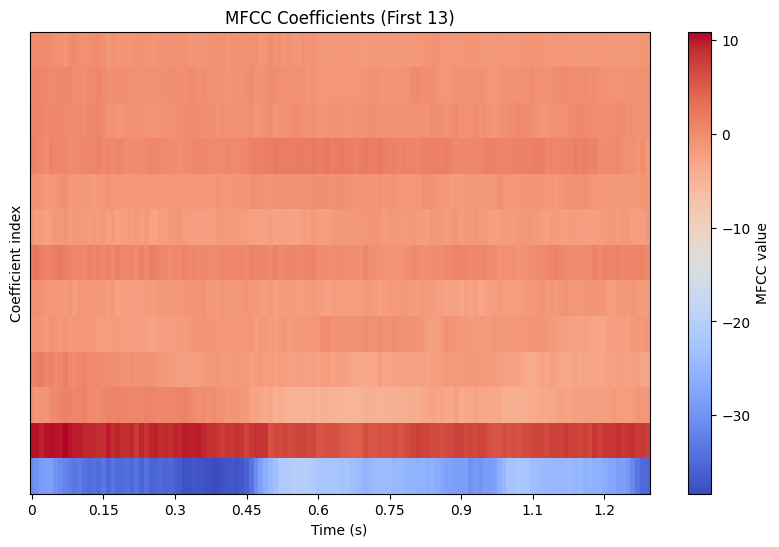

In [9]:
# =============================
# STEP 6 — Apply DCT to get MFCCs
# =============================
mfccs = dct(log_energies, type=2, axis=1, norm='ortho')[:, :13]

plt.figure(figsize=(10, 6))
librosa.display.specshow(
    mfccs.T,
    x_axis='time', sr=sr, hop_length=hop_length
)
plt.colorbar(label='MFCC value')
plt.title("MFCC Coefficients (First 13)")
plt.ylabel("Coefficient index")
plt.xlabel("Time (s)")
plt.show()


WHAT IS DCT?
------------
DCT = Discrete Cosine Transform
- Represents a sequence as a sum of cosine waves with different frequencies and amplitudes.
- Similar to Fourier Transform but uses only cosine waves (no sine).
- In MFCCs, DCT decorrelates the log filter bank energies → reduces redundancy.
- Also achieves energy compaction: most information is in the first few coefficients.

WHY USE DCT IN MFCC?
- After log compression, filter bank energies are still correlated (neighboring bands are similar).
- DCT turns them into uncorrelated values.
- We can then keep only the first N coefficients (low-frequency cosines), discarding fine details (noise).


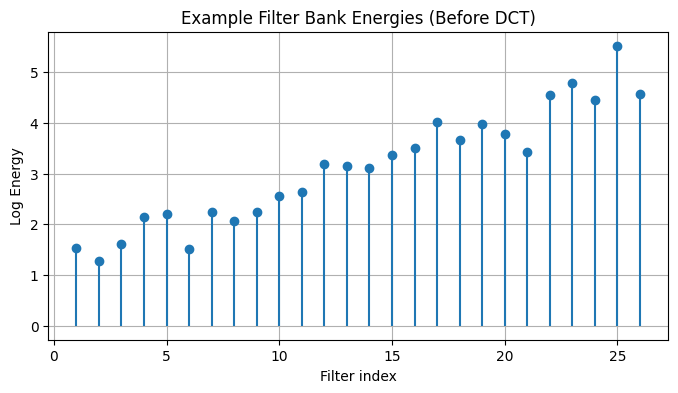

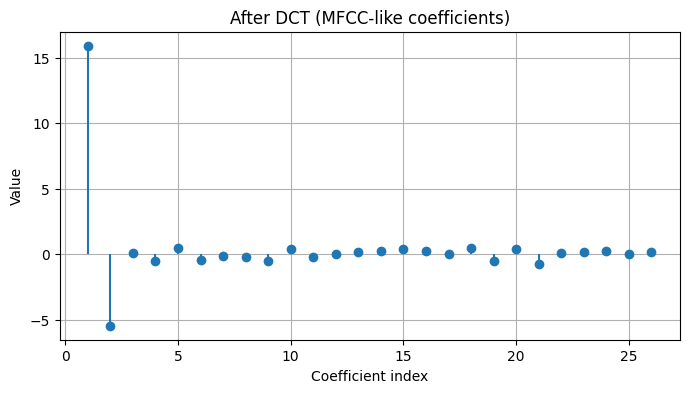

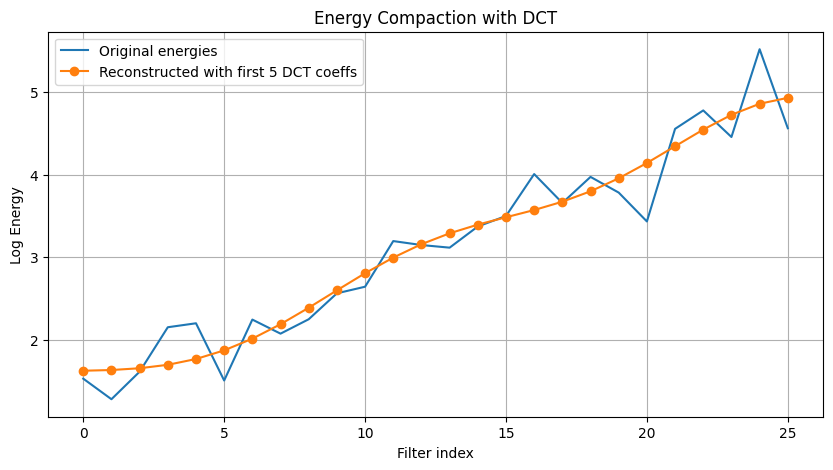

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

# =========================================
# TEXT EXPLANATION
# =========================================
print("WHAT IS DCT?")
print("------------")
print("DCT = Discrete Cosine Transform")
print("- Represents a sequence as a sum of cosine waves with different frequencies and amplitudes.")
print("- Similar to Fourier Transform but uses only cosine waves (no sine).")
print("- In MFCCs, DCT decorrelates the log filter bank energies → reduces redundancy.")
print("- Also achieves energy compaction: most information is in the first few coefficients.")
print("\nWHY USE DCT IN MFCC?")
print("- After log compression, filter bank energies are still correlated (neighboring bands are similar).")
print("- DCT turns them into uncorrelated values.")
print("- We can then keep only the first N coefficients (low-frequency cosines), discarding fine details (noise).")

# =========================================
# CREATE EXAMPLE SIGNAL (like log filter bank energies)
# =========================================
np.random.seed(0)
filter_bank_energies = np.linspace(1, 5, 26) + np.random.normal(0, 0.3, 26)

plt.figure(figsize=(8, 4))
plt.stem(range(1, 27), filter_bank_energies, basefmt=" ")
plt.title("Example Filter Bank Energies (Before DCT)")
plt.xlabel("Filter index")
plt.ylabel("Log Energy")
plt.grid(True)
plt.show()

# =========================================
# APPLY DCT
# =========================================
mfcc_like = dct(filter_bank_energies, type=2, norm='ortho')

plt.figure(figsize=(8, 4))
plt.stem(range(1, 27), mfcc_like, basefmt=" ")
plt.title("After DCT (MFCC-like coefficients)")
plt.xlabel("Coefficient index")
plt.ylabel("Value")
plt.grid(True)
plt.show()

# =========================================
# SHOW ENERGY COMPACTION (reconstruction from first few coefficients)
# =========================================
keep_N = 5
reconstructed = idct(np.concatenate([mfcc_like[:keep_N], np.zeros(len(mfcc_like)-keep_N)]),
                     type=2, norm='ortho')

plt.figure(figsize=(10, 5))
plt.plot(filter_bank_energies, label="Original energies")
plt.plot(reconstructed, 'o-', label=f"Reconstructed with first {keep_N} DCT coeffs")
plt.title("Energy Compaction with DCT")
plt.xlabel("Filter index")
plt.ylabel("Log Energy")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
import sounddevice as sd
import soundfile as sf
import os

# Ensure audio_data folder exists
os.makedirs("audio_data", exist_ok=True)

# List of recordings to make (speaker, scenario, filename)
recordings = [
    ("stefan", "same intonation, same speed", "stefan_same_intonation_same_speed.wav"),
    ("stefan", "same intonation, different speed", "stefan_same_intonation_diff_speed.wav"),
    ("stefan", "different intonation, same speed", "stefan_diff_intonation_same_speed.wav"),
    ("martin", "same intonation, same speed", "martin_same_intonation_same_speed.wav"),
    ("martin", "same intonation, different speed", "martin_same_intonation_diff_speed.wav"),
    ("martin", "different intonation, same speed", "martin_diff_intonation_same_speed.wav"),
]

sr = 16000  # Sample rate
duration = 3  # Recording duration in seconds

for speaker, desc, filename in recordings:
    input(f"\nPress Enter to start recording for {speaker.upper()} - {desc}...")
    print(f"Recording now: {speaker} - {desc}")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype='float32')
    sd.wait()
    filepath = os.path.join("audio_data", filename)
    sf.write(filepath, audio, sr)
    print(f"Saved: {filepath}")


Recording now: stefan - same intonation, same speed
Saved: audio_data/stefan_same_intonation_same_speed.wav
Recording now: stefan - same intonation, different speed
Saved: audio_data/stefan_same_intonation_diff_speed.wav
Recording now: stefan - different intonation, same speed
Saved: audio_data/stefan_diff_intonation_same_speed.wav
Recording now: martin - same intonation, same speed
Saved: audio_data/martin_same_intonation_same_speed.wav
Recording now: martin - same intonation, different speed
Saved: audio_data/martin_same_intonation_diff_speed.wav
Recording now: martin - different intonation, same speed
Saved: audio_data/martin_diff_intonation_same_speed.wav


In [15]:
import librosa
import soundfile as sf
import os
import numpy as np

# Folder containing the wav files
folder = "audio_data"

# Silence trimming parameters
top_db = 20  # Lower = more aggressive trimming

for file in os.listdir(folder):
    if file.lower().endswith(".wav"):
        path = os.path.join(folder, file)
        
        # Load audio
        y, sr = librosa.load(path, sr=None)
        
        # Trim silence from start and end
        trimmed, index = librosa.effects.trim(y, top_db=top_db)
        
        # Normalize to avoid volume loss
        trimmed = trimmed / np.max(np.abs(trimmed))
        
        # Save back to the same file
        sf.write(path, trimmed, sr)
        
        print(f"Trimmed and saved: {file}")


Trimmed and saved: martin_same_intonation_same_speed.wav
Trimmed and saved: zdaj_grem_domov.wav
Trimmed and saved: martin_same_intonation_diff_speed.wav
Trimmed and saved: martin_diff_intonation_same_speed.wav
Trimmed and saved: stefan_diff_intonation_same_speed.wav
Trimmed and saved: stefan_same_intonation_diff_speed.wav
Trimmed and saved: stefan_same_intonation_same_speed.wav


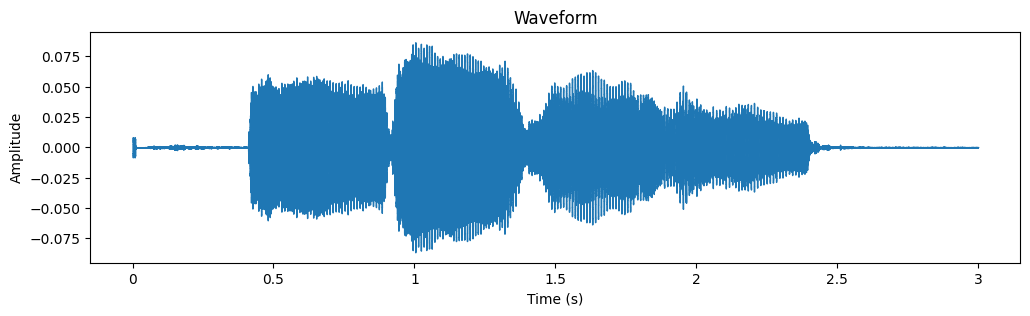

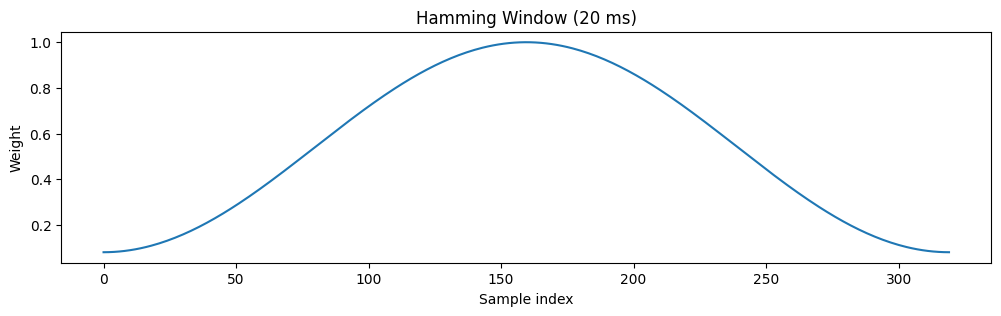

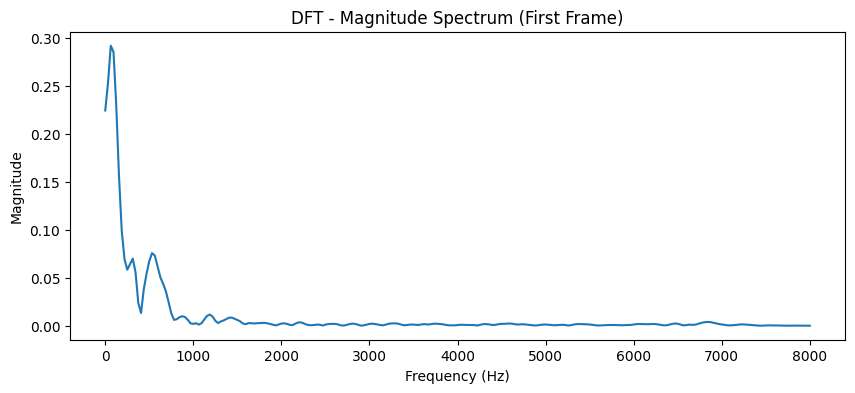

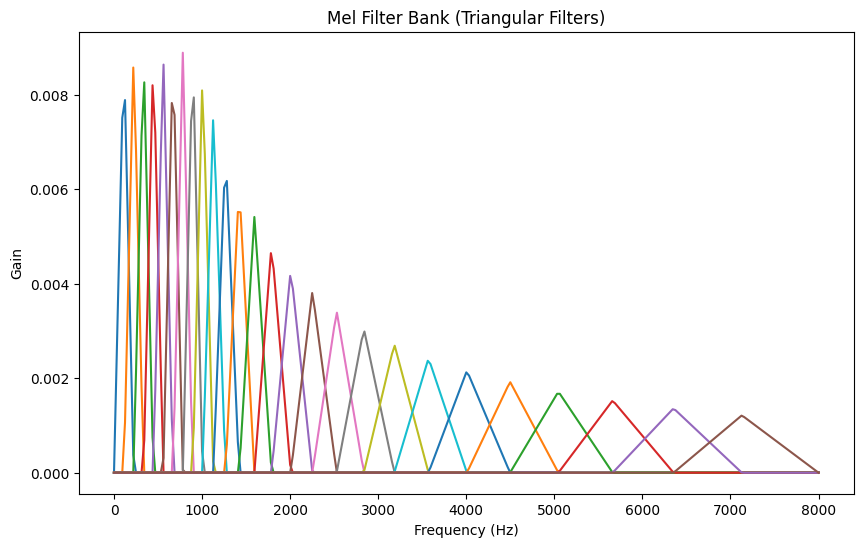

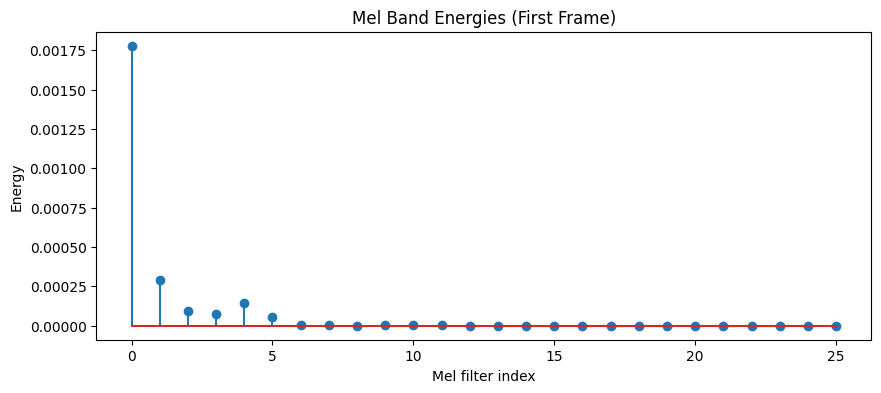

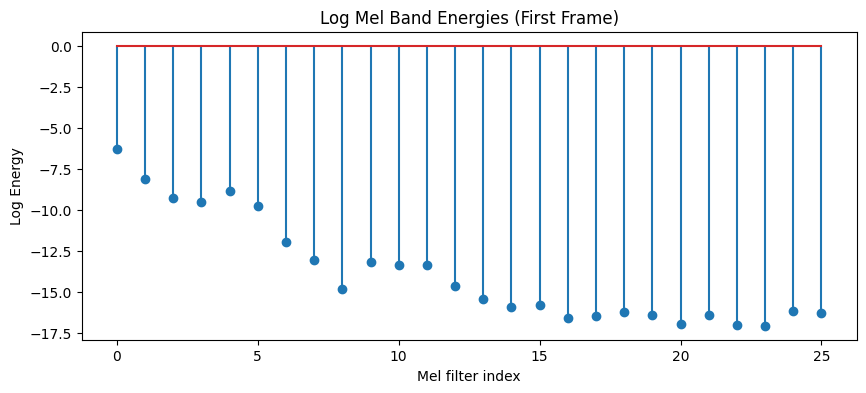

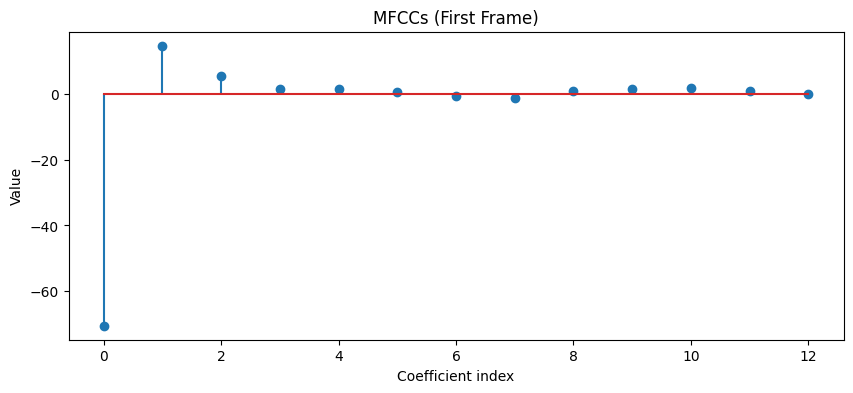

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.fftpack import dct

file_path = "audio_data/stefan_same_intonation_same_speed.wav"

# 1. LOAD AUDIO
y, sr = librosa.load(file_path, sr=16000)
plt.figure(figsize=(12, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# 2. FRAME + HAMMING WINDOW
frame_length = int(0.02 * sr)  # 20 ms
hop_length = int(0.01 * sr)    # 10 ms hop
frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length).T
hamming_window = np.hamming(frame_length)
windowed_frames = frames * hamming_window

plt.figure(figsize=(12, 3))
plt.plot(hamming_window)
plt.title("Hamming Window (20 ms)")
plt.xlabel("Sample index")
plt.ylabel("Weight")
plt.show()

# 3. FIND LOUDEST FRAME (highest energy)
frame_energies = np.sum(windowed_frames**2, axis=1)
loudest_frame_index = np.argmax(frame_energies)
loudest_frame = windowed_frames[loudest_frame_index]

# DFT for the loudest frame
n_fft = 512
fft_spectrum = np.fft.rfft(loudest_frame, n=n_fft)
magnitude_spectrum = np.abs(fft_spectrum)
freqs = np.fft.rfftfreq(n_fft, d=1/sr)

plt.figure(figsize=(10, 4))
plt.plot(freqs, magnitude_spectrum)
plt.title(f"DFT - Magnitude Spectrum (Frame {loudest_frame_index}, Loudest Frame)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

# 4. MEL FILTER BANK
n_mels = 26
mel_filter_bank = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels, fmin=0, fmax=sr/2)

plt.figure(figsize=(10, 6))
for m in mel_filter_bank:
    plt.plot(freqs, m)
plt.title("Mel Filter Bank (Triangular Filters)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain")
plt.show()

# 5. APPLY MEL FILTERS TO MAGNITUDE SPECTRUM
mel_energies = np.dot(mel_filter_bank, magnitude_spectrum**2)  # power spectrum
plt.figure(figsize=(10, 4))
plt.stem(mel_energies)
plt.title("Mel Band Energies (Loudest Frame)")
plt.xlabel("Mel filter index")
plt.ylabel("Energy")
plt.show()

# 6. LOGARITHM
log_mel_energies = np.log(mel_energies + 1e-9)
plt.figure(figsize=(10, 4))
plt.stem(log_mel_energies)
plt.title("Log Mel Band Energies (Loudest Frame)")
plt.xlabel("Mel filter index")
plt.ylabel("Log Energy")
plt.show()

# 7. DCT → MFCC
mfccs_loudest_frame = dct(log_mel_energies, type=2, norm='ortho')[:13]
plt.figure(figsize=(10, 4))
plt.stem(mfccs_loudest_frame)
plt.title("MFCCs (Loudest Frame)")
plt.xlabel("Coefficient index")
plt.ylabel("Value")
plt.show()
